In [1]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'avenir',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)

from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list,fcluster
import matplotlib.patches as mpatches

from finches import CALVADOS_frontend, Mpipi_frontend
cf = CALVADOS_frontend()
mf = Mpipi_frontend()
from sparrow.data.amino_acids import VALID_AMINO_ACIDS
from tqdm import tqdm
import itertools
import protfasta
from sparrow import Protein


/Users/alex/Dropbox/WASHU/Holehouse/tools/finches/finches/finches/forcefields/calvados.py:235: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.038286503882254706' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  r.loc['H','q'] = 1. / ( 1 + 10**(self.pH-6) )


In [2]:
mode = 'calvados'

# note - dipeptides give much cleaner clusters than tripeptides...
all_peptides = []
for idx, aa1 in enumerate(VALID_AMINO_ACIDS):
    
    for aa2 in VALID_AMINO_ACIDS[idx:]:
        all_peptides.append((aa1 + aa2)*10)
    



In [3]:
all_eps =[]
for s1 in tqdm(all_peptides):
    tmp = []
    for s2 in all_peptides:
        if mode == 'calvados':
            tmp.append(cf.epsilon(s1,s2))
        elif mode == 'mpipi':
            tmp.append(mf.epsilon(s1,s2))
    all_eps.append(tmp)

all_eps = np.array(all_eps)

100%|████████████████████████████████████████████████████| 210/210 [00:04<00:00, 45.22it/s]


In [4]:
row_linkage = linkage(all_eps, method='ward', optimal_ordering=True)
col_linkage = linkage(all_eps.T, method='ward',optimal_ordering=True)  # Transpose for column clustering
row_order = leaves_list(row_linkage)
col_order = leaves_list(col_linkage)

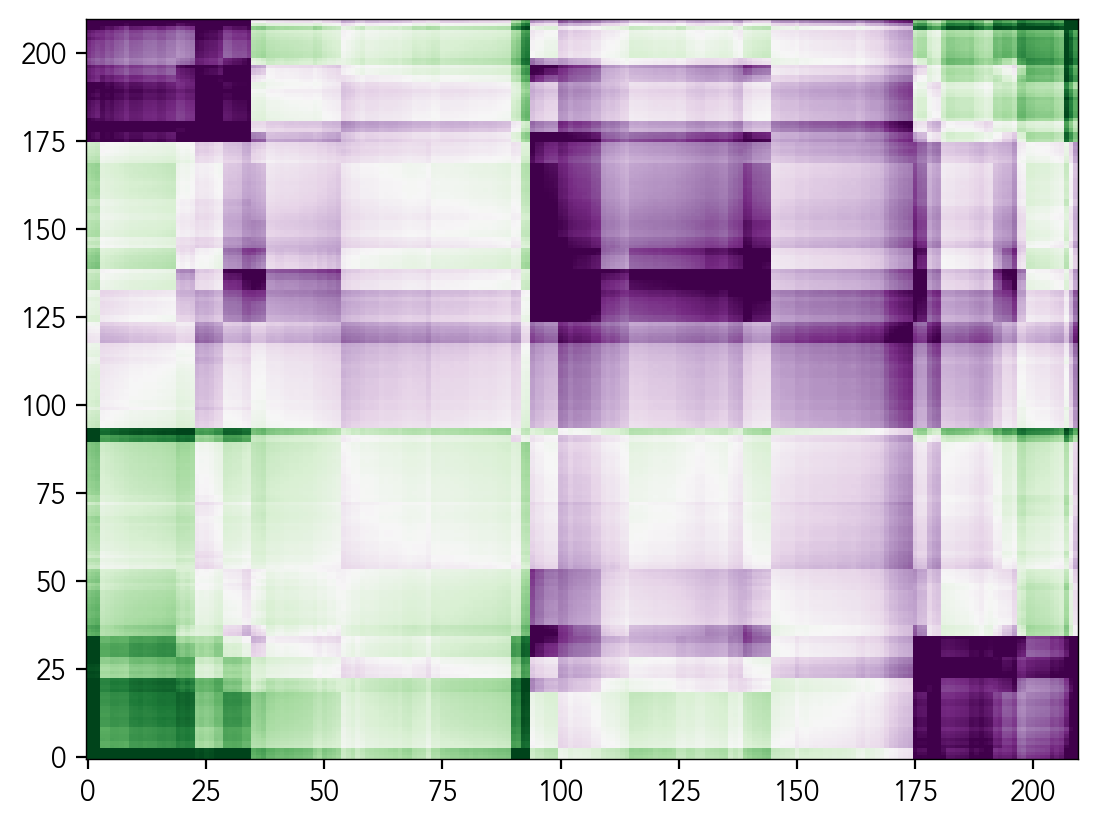

In [5]:
reordered_matrix = all_eps[row_order, :][:, col_order]

if mode == 'calvados':
    plt.imshow(reordered_matrix, vmin=-25, vmax=25,cmap='PRGn',interpolation='None', aspect='auto', origin='lower')
elif mode == 'mpipi':
    plt.imshow(reordered_matrix, vmin=-15, vmax=15,cmap='PRGn',interpolation='None', aspect='auto', origin='lower')

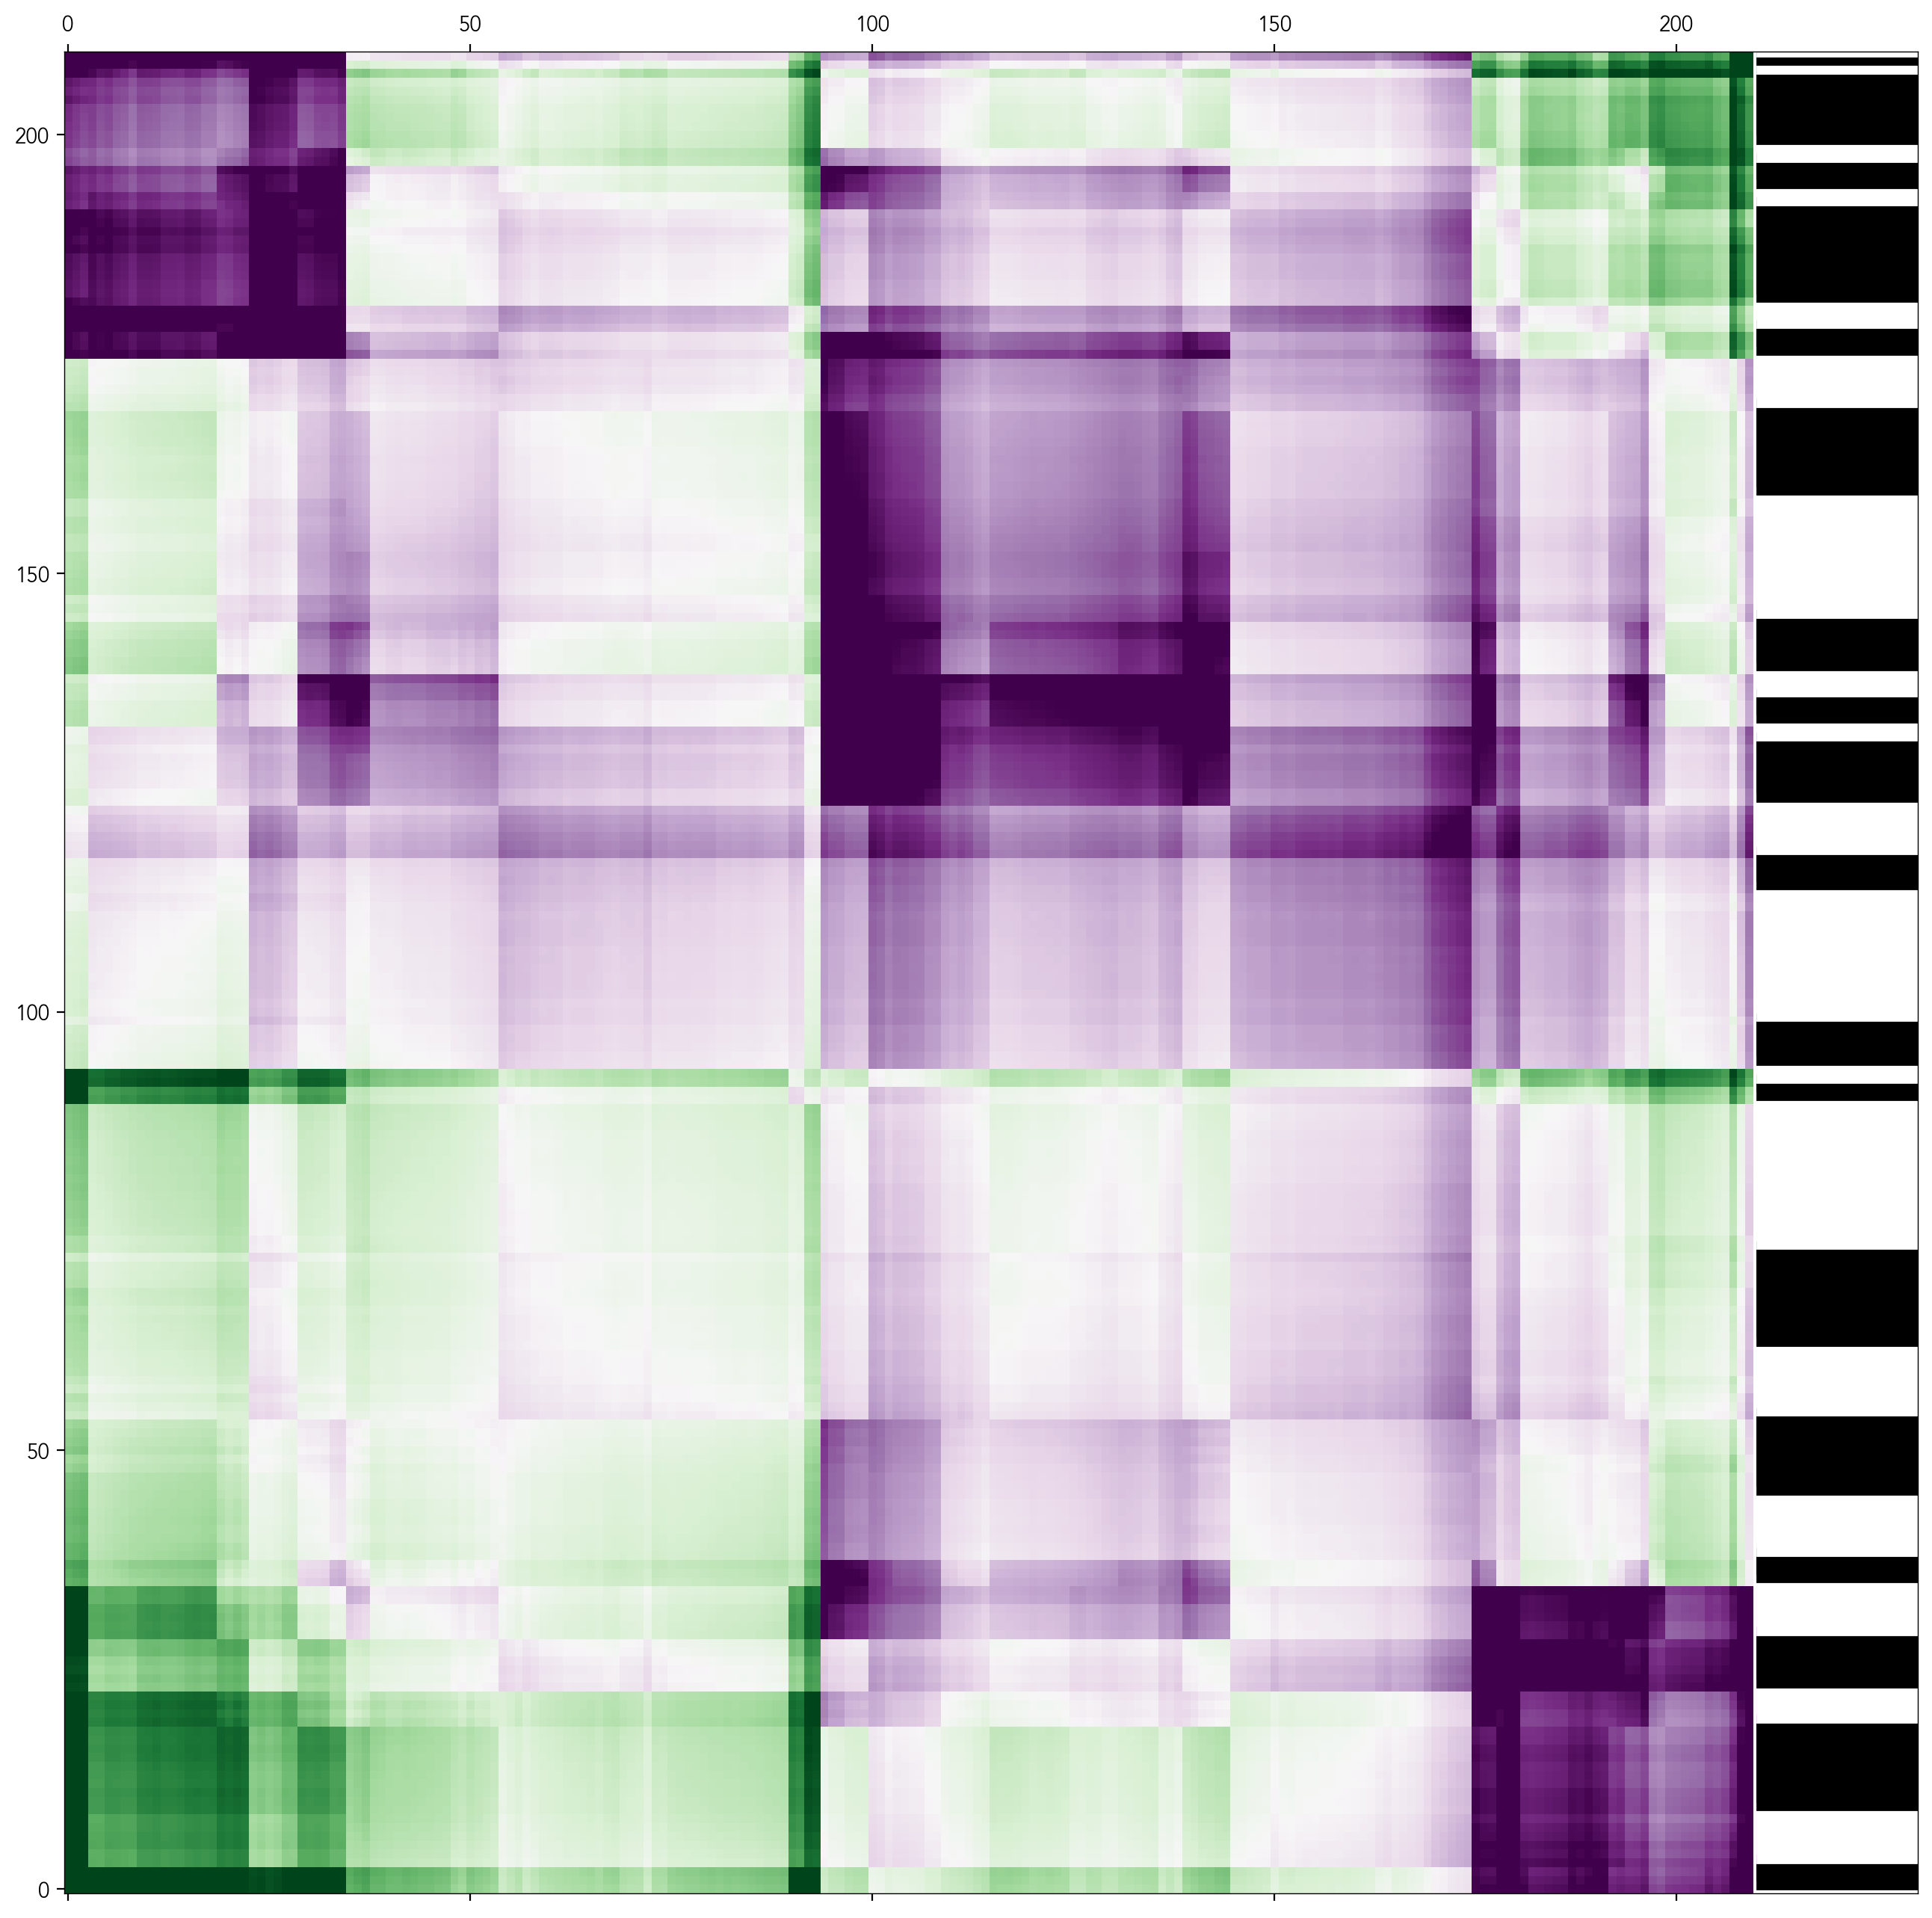

In [6]:
# define the number of clusters (0.5)
nclusters=18

# find nclusters*2 clusters using maxclust
clusters = fcluster(row_linkage, t=nclusters*2, criterion='maxclust')

# now plot everything
fig, ax = plt.subplots(figsize=(16, 16))


cax = ax.matshow(reordered_matrix, aspect='auto', origin='lower', cmap='PRGn', vmin=-25, vmax=25)

# Add a color bar for the heatmap

# cluster membership sidebar - rather than the chaos of a dendrogram we're gonna alternative white/black to deliniate
# cluster identity

current_cluster = clusters[row_order][0]
possible_colors = ['k','w']
color_idx = 0
                   
current_color = 'k'
color_labels = []
color_labels.append(current_color)

for c in clusters[row_order][1:]:
    if c == current_cluster:
         pass
    else:
        current_cluster = c
        
        if color_idx + 1 == len(possible_colors):
            color_idx = 0
            current_color = possible_colors[color_idx]
        else:
            color_idx = color_idx + 1            
            current_color = possible_colors[color_idx]
        
    color_labels.append(current_color)

#cluster_colors = ['k', 'w']*(nclusters)
#color_labels = [cluster_colors[i-1] for i in clusters[row_order]]  # Match cluster ID to color

offset = 20
for ypos, c in enumerate(color_labels):
    ax.add_patch(mpatches.Rectangle((reordered_matrix.shape[0], ypos), offset, 10, color=c, edgecolor=None))

ax.set_xlim(right=reordered_matrix.shape[0]+offset)  


plt.savefig(f'fingerprint_clusters_{mode}.pdf')

In [7]:
cluster_indices_dict = {}
for index, cluster_id in enumerate(clusters):
    if cluster_id not in cluster_indices_dict:
        cluster_indices_dict[cluster_id] = []
    cluster_indices_dict[cluster_id].append(index)


# define the domains in each cluster (1,2,... from bottom to top)
cluster_domains = {}
for i in range(1, 1+nclusters*2):

    cluster_domains[i] = []
    for idx in cluster_indices_dict[i]:
        cluster_domains[i].append(all_peptides[idx])
    

In [8]:
outdict = {}
for k in cluster_domains:
    for idx, s in enumerate(cluster_domains[k]):
        outdict[f"{k}_{idx}"]  = s
protfasta.write_fasta(outdict, f'fingerprint_clusters_{mode}.fasta')        

In [9]:
cluster_domains

{1: ['DDDDDDDDDDDDDDDDDDDD', 'DEDEDEDEDEDEDEDEDEDE', 'EEEEEEEEEEEEEEEEEEEE'],
 2: ['CDCDCDCDCDCDCDCDCDCD',
  'CECECECECECECECECECE',
  'DGDGDGDGDGDGDGDGDGDG',
  'DHDHDHDHDHDHDHDHDHDH',
  'EGEGEGEGEGEGEGEGEGEG',
  'EHEHEHEHEHEHEHEHEHEH'],
 3: ['DNDNDNDNDNDNDNDNDNDN',
  'DPDPDPDPDPDPDPDPDPDP',
  'DQDQDQDQDQDQDQDQDQDQ',
  'DSDSDSDSDSDSDSDSDSDS',
  'DTDTDTDTDTDTDTDTDTDT',
  'ENENENENENENENENENEN',
  'EPEPEPEPEPEPEPEPEPEP',
  'EQEQEQEQEQEQEQEQEQEQ',
  'ESESESESESESESESESES',
  'ETETETETETETETETETET'],
 4: ['ADADADADADADADADADAD',
  'AEAEAEAEAEAEAEAEAEAE',
  'DVDVDVDVDVDVDVDVDVDV',
  'EVEVEVEVEVEVEVEVEVEV'],
 5: ['DFDFDFDFDFDFDFDFDFDF',
  'DWDWDWDWDWDWDWDWDWDW',
  'DYDYDYDYDYDYDYDYDYDY',
  'EFEFEFEFEFEFEFEFEFEF',
  'EWEWEWEWEWEWEWEWEWEW',
  'EYEYEYEYEYEYEYEYEYEY'],
 6: ['DIDIDIDIDIDIDIDIDIDI',
  'DLDLDLDLDLDLDLDLDLDL',
  'DMDMDMDMDMDMDMDMDMDM',
  'EIEIEIEIEIEIEIEIEIEI',
  'ELELELELELELELELELEL',
  'EMEMEMEMEMEMEMEMEMEM'],
 7: ['AAAAAAAAAAAAAAAAAAAA', 'AVAVAVAVAVAVAVAVAVAV', 'VVVVVVVVVVVVVVVV

In [11]:
manually_curated = protfasta.read_fasta(f'fingerprint_{mode}_renamed.fasta')

In [12]:
for idx, k in enumerate(manually_curated):
    print(f'Cluster {idx+1}')
    Protein(manually_curated[k]).show_sequence(blocksize=20)

Cluster 1


Cluster 2


Cluster 3


Cluster 4


Cluster 5


Cluster 6


Cluster 7


Cluster 8


Cluster 9


Cluster 10


Cluster 11


Cluster 12


Cluster 13


Cluster 14


Cluster 15


Cluster 16


Cluster 17


Cluster 18


Cluster 19


Cluster 20


Cluster 21


Cluster 22


Cluster 23


Cluster 24


Cluster 25


Cluster 26


Cluster 27


Cluster 28


Cluster 29


Cluster 30


Cluster 31


Cluster 32


Cluster 33


Cluster 34


Cluster 35


Cluster 36
